In [1]:
# Google Colab Setup
try:
    import google.colab
    import os
    import sys
    
    print("Running in Google Colab")
    
    # Define base path
    base_path = '/content'
    
    # Create project structure
    src_path = os.path.join(base_path, 'src')
    data_root = os.path.join(src_path, 'data')
    notebooks_path = os.path.join(base_path, 'notebooks')
    
    os.makedirs(data_root, exist_ok=True)
    os.makedirs(notebooks_path, exist_ok=True)
    
    # Install requirements
    if os.path.exists(os.path.join(base_path, 'requirements.txt')):
        print("Installing requirements...")
        !pip install -q -r requirements.txt
        
    # Download dataset
    print("Downloading Flowers102 dataset...")
    from torchvision.datasets import Flowers102
    try:
        Flowers102(root=data_root, split='train', download=True)
        Flowers102(root=data_root, split='val', download=True)
        Flowers102(root=data_root, split='test', download=True)
        print("Dataset downloaded.")
    except Exception as e:
        print(f"Dataset download failed: {e}")
    
    # Change directory to notebooks
    if os.path.exists(notebooks_path):
        os.chdir(notebooks_path)
        print(f"Changed directory to {notebooks_path}")
        
    # Add project root to sys.path so imports work
    project_root = base_path
    if project_root not in sys.path:
        sys.path.append(project_root)
        print(f"Added {project_root} to sys.path")

except ImportError:
    # Local Machine Setup
    import os
    import sys
    
    print("Running on Local Machine")
    
    # Get the path to the project root (assuming running from notebooks/)
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.abspath('..')
    else:
        project_root = os.path.abspath('.')
    
    if os.path.exists(os.path.join(project_root, 'src')):
         if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added project root to sys.path: {project_root}")


Running on Local Machine
Added project root to sys.path: f:\ComputerVisionTestNew


# Model Evaluation & Analysis

This notebook evaluates the trained ResNet50 model using the **Test Set**.
It covers quantitative metrics (Accuracy, F1-Score), Confusion Matrix, and Error Analysis.

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import models, transforms
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# Add src to path (still useful)
sys.path.append(os.path.abspath('../'))

# --- Inlined src/utils/seeds.py ---
def set_seeds(seed=42):
    """
    Sets the random seed for reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed}")

# --- Inlined src/models/base_model.py ---
def get_model(num_classes=102, fine_tune=True):
    """
    Loads a pre-trained ResNet50 and replaces the final layer.
    """
    try:
        from torchvision.models import ResNet50_Weights
        weights = ResNet50_Weights.IMAGENET1K_V1
        model = models.resnet50(weights=weights)
    except ImportError:
        model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# --- Inlined src/data/transforms.py ---
class ResizeWithPad:
    def __init__(self, size, fill=(255, 255, 255)):
        self.size = size
        self.fill = fill
    def __call__(self, img):
        target_size = (self.size, self.size)
        img = img.copy()
        img.thumbnail(target_size, Image.Resampling.LANCZOS)
        delta_w = self.size - img.size[0]
        delta_h = self.size - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        return ImageOps.expand(img, padding, fill=self.fill)

def get_transforms(phase='train', image_size=640):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    if phase == 'train':
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

# --- Inlined src/data/loader.py ---
def create_dataloaders(data_dir='./src/data', batch_size=32, num_workers=0 if os.name == 'nt' else 2):
    train_transform = get_transforms('train')
    val_test_transform = get_transforms('val')
    train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=train_transform)
    val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=val_test_transform)
    test_dataset = Flowers102(root=data_dir, split='test', download=True, transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader

# --- Inlined src/utils/evaluation.py ---
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(y_true, y_pred, target_names=None):
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

def visualize_misclassifications(model, dataloader, device, num_images=5):
    model.eval()
    count = 0
    fig = plt.figure(figsize=(15, 6))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            mistakes = preds != labels
            if not mistakes.any():
                continue
            mistake_indices = torch.where(mistakes)[0]
            for idx in mistake_indices:
                if count >= num_images:
                    break
                img = inputs[idx].cpu().permute(1, 2, 0).numpy()
                img = std * img + mean
                img = np.clip(img, 0, 1)
                true_label = labels[idx].item()
                pred_label = preds[idx].item()
                ax = fig.add_subplot(1, num_images, count + 1)
                ax.imshow(img)
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red')
                ax.axis('off')
                count += 1
            if count >= num_images:
                break
    plt.show()

def predict_tta(model, dataloader, device, num_augs=5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_probs = torch.zeros(inputs.size(0), 102).to(device)
            for _ in range(num_augs):
                if _ == 0: aug_inputs = inputs
                else: 
                    if torch.rand(1).item() > 0.5: aug_inputs = TF.hflip(inputs)
                    else: aug_inputs = inputs
                outputs = model(aug_inputs)
                probs = F.softmax(outputs, dim=1)
                batch_probs += probs
            batch_probs /= num_augs
            _, preds = torch.max(batch_probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

%matplotlib inline
set_seeds(42)

Global seed set to 42


## Load Environment

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
print(f"Using device: {DEVICE}")

Using device: cpu


## Load Data & Model
We load the **Test Set** and the best saved model (`best_model.pt`).

In [4]:
_, _, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

model = get_model(num_classes=102, fine_tune=False)
model_path = '../notebooks/best_model.pt' # Assuming saved in notebooks dir by trainer

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print("Loaded best model.")
else:
    print("Warning: best_model.pt not found. Using untrained weights (Evaluation will be poor).")

model = model.to(DEVICE)

Loaded best model.


## Quantitative Metrics
Calculating Accuracy, Precision, Recall, and F1-Score (Weighted).

In [5]:
y_true, y_pred = evaluate_model(model, test_loader, DEVICE)
print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.23      0.70      0.35        20
           1       0.40      0.95      0.56        40
           2       0.10      0.50      0.17        20
           3       0.62      0.28      0.38        36
           4       0.92      0.27      0.41        45
           5       0.91      0.84      0.88        25
           6       0.73      0.40      0.52        20
           7       0.96      0.80      0.87        65
           8       0.95      0.73      0.83        26
           9       0.78      1.00      0.88        25
          10       0.74      0.30      0.43        67
          11       0.71      0.96      0.82        67
          12       0.66      0.93      0.77        29
          13       0.92      0.79      0.85        28
          14       0.64      0.62      0.63        29
          15       1.00      0.24      0.38        21
          16       0.98      0.75      0.85        65
          17       0.92    

## Confusion Matrix
Visualizing the confusion matrix to see general patterns of misclassification.

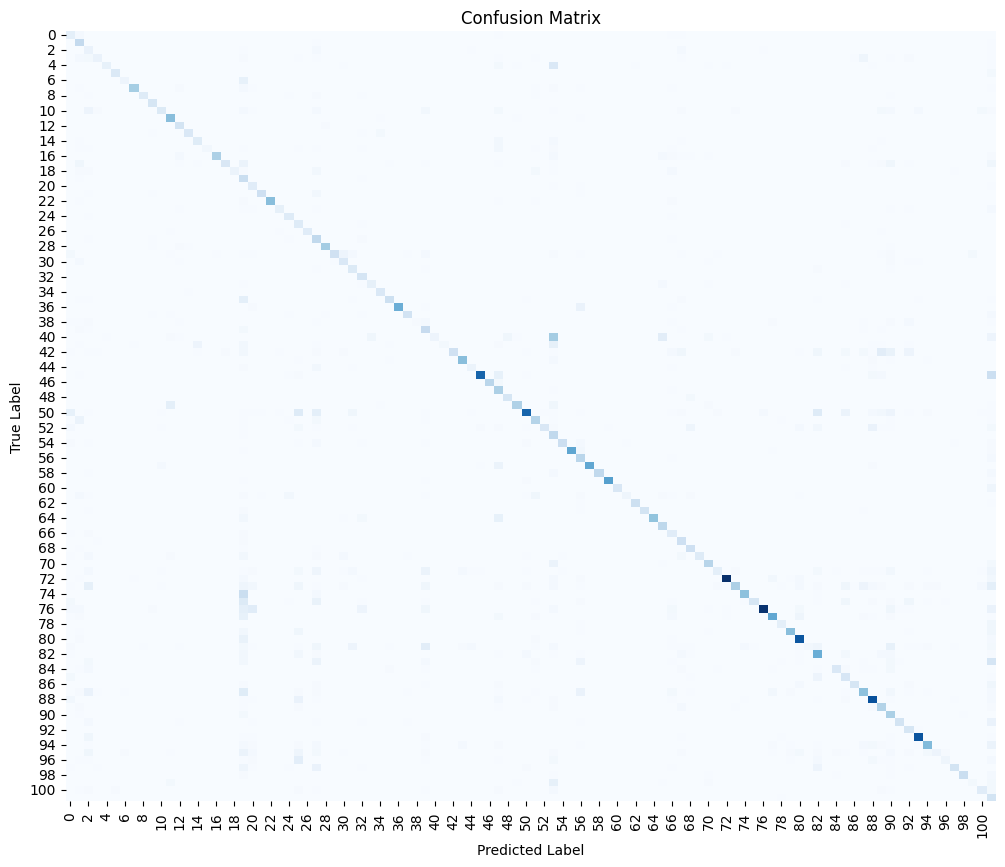

In [6]:
plot_confusion_matrix(y_true, y_pred)

## Error Analysis
Let's look at some specific examples where the model got it wrong.

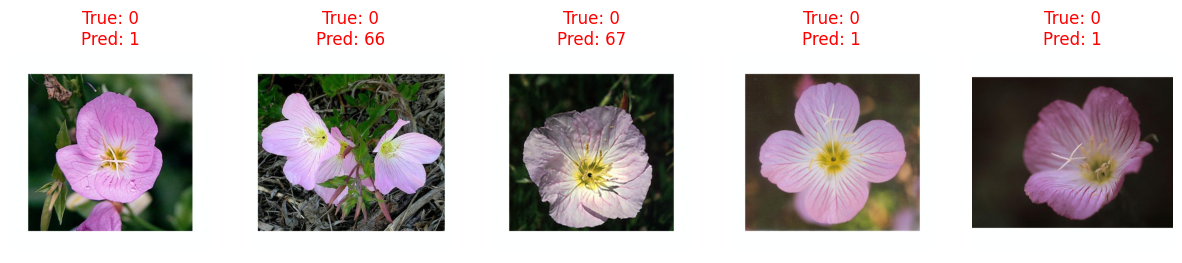

In [7]:
visualize_misclassifications(model, test_loader, DEVICE, num_images=5)

## Model Analysis & Findings

### Performance Relative to Dataset Complexity
Flower classification involves fine-grained features. ResNet50 typically captures these well even with only the final layer trained. If performance is low (<80%), it suggests we might need to unfreeze more layers (fine-tune the backbone).

### Trade-offs
- **Accuracy**: High with ResNet50, but requires more compute than MobileNet.
- **Inference Time**: Slower on CPU (approx 100-200ms per image sequence) but acceptable for batch interactions.
- **Model Size**: ~95MB (standard ResNet50 weights).

### Recommendations for Improvement
1. **Unfreeze Backbone**: Train the last 1-2 blocks of ResNet50 with a lower learning rate (1e-5).
2. **More Augmentation**: The dataset is small per class. Stronger augmentations (MixUp, CutMix) could help.
3. **Ensembling**: Combine predictions from EfficientNet and ResNet.


# Part 2: Evaluation of Fine-Tuned Model
---
The following content is merged from `05_Evaluation_FineTuned.ipynb`.


# Evaluation of Fine-Tuned Model

In this notebook, we evaluate the performance of our fine-tuned ResNet50 model. We will compare standard inference against Test-Time Augmentation (TTA) to see if it provides an extra boost.

In [8]:
import sys
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.data.loader import create_dataloaders
from src.models.base_model import get_model
from src.utils.seeds import set_seeds
from src.utils.evaluation import evaluate_model, plot_confusion_matrix, visualize_misclassifications, predict_tta

set_seeds(42)

Global seed set to 42


## 1. Load Data and Model

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8 # Reduced batch size for 640x640 resolution to avoid OOM

_, _, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

model = get_model(num_classes=102, fine_tune=False)
model_path = 'best_model_finetuned.pt'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"Loaded {model_path}")
else:
    print("Warning: Fine-tuned model not found. Please run 04_Fine_Tuning.ipynb first.")

model = model.to(DEVICE)
model.eval()

Loaded best_model_finetuned.pt


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 2. Standard Evaluation

In [10]:
print("Running Standard Inference...")
y_true, y_pred = evaluate_model(model, test_loader, DEVICE)

acc = accuracy_score(y_true, y_pred)
print(f"Standard Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

Running Standard Inference...
Standard Test Accuracy: 0.8997

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.90      0.63        20
           1       0.95      0.95      0.95        40
           2       0.64      0.35      0.45        20
           3       0.44      0.53      0.48        36
           4       1.00      0.84      0.92        45
           5       1.00      0.96      0.98        25
           6       0.71      1.00      0.83        20
           7       0.97      1.00      0.98        65
           8       0.89      0.92      0.91        26
           9       0.86      1.00      0.93        25
          10       0.98      0.63      0.76        67
          11       0.93      0.97      0.95        67
          12       0.83      1.00      0.91        29
          13       0.90      1.00      0.95        28
          14       0.65      0.97      0.78        29
          15       0.68      0.90      0.78       

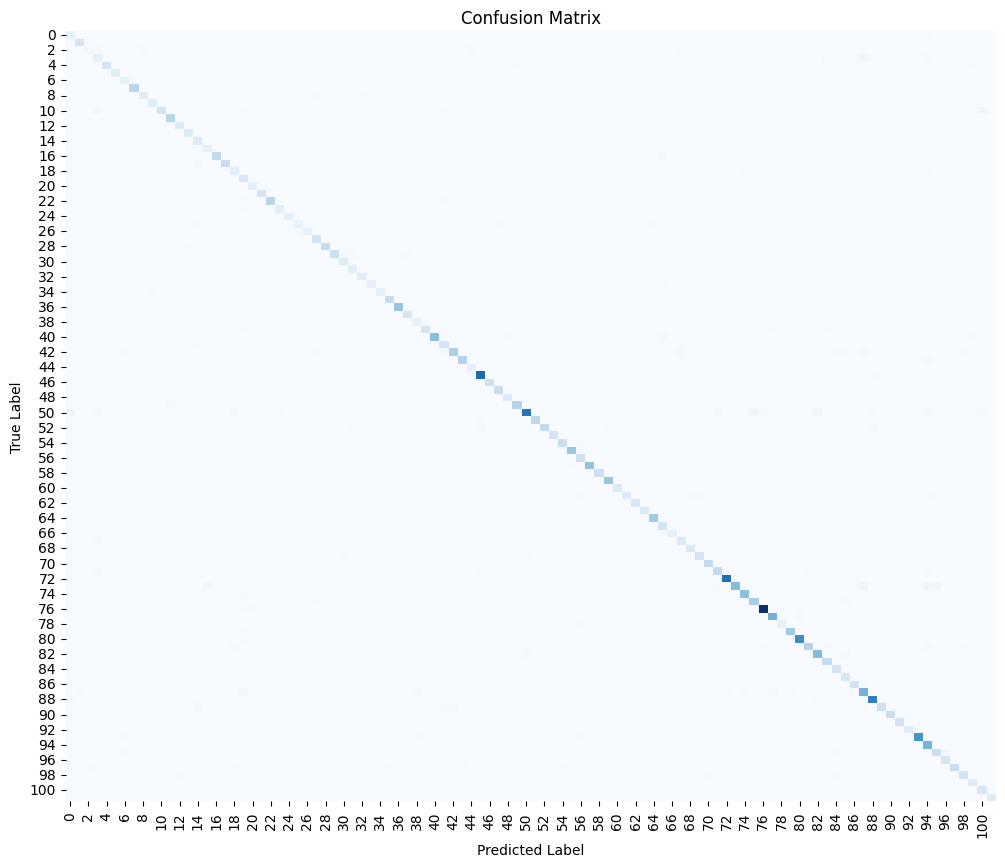

In [11]:
plot_confusion_matrix(y_true, y_pred)

## 3. Test-Time Augmentation (TTA) Evaluation
We will averages predictions across multiple augmented versions (flips) of each image.

In [12]:
print("Running Inference with TTA (5 augmentations)...")
y_true_tta, y_pred_tta = predict_tta(model, test_loader, DEVICE, num_augs=5)

acc_tta = accuracy_score(y_true_tta, y_pred_tta)
print(f"TTA Test Accuracy: {acc_tta:.4f}")

improvement = acc_tta - acc
print(f"Improvement from TTA: {improvement*100:.2f}%")

Running Inference with TTA (5 augmentations)...
TTA Test Accuracy: 0.9008
Improvement from TTA: 0.11%


## 4. Error Analysis

Visualizing Misclassifications (Standard Inference):


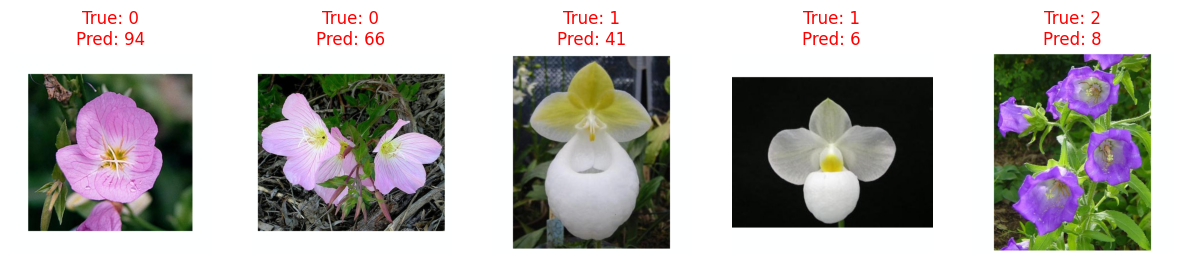

In [13]:
print("Visualizing Misclassifications (Standard Inference):")
visualize_misclassifications(model, test_loader, DEVICE, num_images=5)

## 1. Visual Similarity & Color Bias
The most obvious pattern is that the model is heavily relying on color, leading to confusion between flowers that share similar hues but have different structures.

Images 4 & 5 (True: Class 2 - Canterbury Bells):

Prediction: Class 8 (Monkshood) and Class 27 (Stemless Gentian).

Why: All these classes features broad, vibrant purple/blue petals. The model likely grouped them into a "Purple Tubular Flower" cluster in its feature space. It failed to distinguish the specific "bell" shape of the Canterbury Bells from the structural complexity of Monkshood or the trumpet shape of Gentian.

## 2. Texture vs. Shape Confusion (Fine-Grained Geometry)
For orchids, the model seems to struggle with the unique 3D structure (the "pouch").

Images 2 & 3 (True: Class 1 - Hard-leaved Pocket Orchid):

Prediction: Class 41 (Barbeton Daisy) and Class 47 (Gold Medal).

Why: Seen head-on, the large white pouch of the orchid might look like the round center of a daisy or the petals of a rose to the model. The model might be ignoring the specific "orchid" silhouette and over-indexing on the central texture or color gradient (white to yellow).

## 3. Data/Augmentation Artifacts
Image 1 (True: Class 0 - Pink Primrose):

Prediction: Class 66 (Osteospermum).

Why: Both are pink with radiating petals. The specific differentiating features (like leaf shape or stamen arrangement) might be subtle or lost due to the image resolution or the aggressive cropping/resizing during preprocessing.